<br/>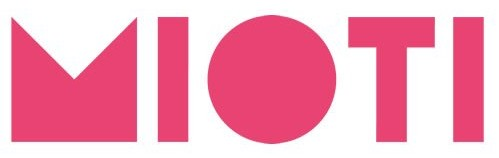<br/><br/>
<center style="color:#888">Machine learning 3</center>
<center style="color:#aaa; margin-top:10px;"><b>Prof. Diego García Morate</b><br>diegogm@faculty.mioti.es</center>
<p style="font-size: 2.5em; text-align:center">Challenge S4: Analizando bosques<br/>

# Objetivos

El objetivo de este challenge es ser capaz de clasificar un dataset de tipos de suelo mediante las técnicas de aprendizaje incremental vistas en el worksheet.

Importante: sólo hay una única restricción: ¡**No puedes en ningún momento de este challenge cargar el dataset completo en memoria!** (a excepción que se indique lo contrario).

## Configuración del entorno

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import sklearn

import random

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Perceptron
import os

## Covertype dataset

El dataset que vamos a utilizar en este challenge se denomina Covertype dataset (https://archive.ics.uci.edu/ml/datasets/covertype). Este dataset está formado por más de 500.000 observaciones de regiones de 30x30m de bosques en el parque nacional Roosevelt en Colorado.

Las variables de las que está compuesto el dataset según la documentación (`dataset/covtype.info`) son las siguientes:

<pre style="font-size:10px">
Name                                     Data Type    Measurement                       Description

Elevation                               quantitative    meters                       Elevation in meters
Aspect                                  quantitative    azimuth                      Aspect in degrees azimuth
Slope                                   quantitative    degrees                      Slope in degrees
Horizontal_Distance_To_Hydrology        quantitative    meters                       Horz Dist to nearest surface water features
Vertical_Distance_To_Hydrology          quantitative    meters                       Vert Dist to nearest surface water features
Horizontal_Distance_To_Roadways         quantitative    meters                       Horz Dist to nearest roadway
Hillshade_9am                           quantitative    0 to 255 index               Hillshade index at 9am, summer solstice
Hillshade_Noon                          quantitative    0 to 255 index               Hillshade index at noon, summer soltice
Hillshade_3pm                           quantitative    0 to 255 index               Hillshade index at 3pm, summer solstice
Horizontal_Distance_To_Fire_Points      quantitative    meters                       Horz Dist to nearest wildfire ignition points
Wilderness_Area (4 binary columns)      qualitative     0 (absence) or 1 (presence)  Wilderness area designation
Soil_Type (40 binary columns)           qualitative     0 (absence) or 1 (presence)  Soil Type designation
Cover_Type (7 types)                    integer         1 to 7                       Forest Cover Type designation
</pre>

Utilizaremos como variable objetivo la última variable `Cover_Type` que indica la categoría de bosque en la que se clasifica ese área:

<pre style="font-size:10px">
Forest Cover Type Classes:	

1 -- Spruce/Fir
2 -- Lodgepole Pine
3 -- Ponderosa Pine
4 -- Cottonwood/Willow
5 -- Aspen
6 -- Douglas-fir
7 -- Krummholz
</pre>

# Análisis previo del dataset


Carga un fragmento del dataset (`dataset/covtype.csv`), verifica que las variables cargadas coinciden con el archivo de información del dataset.

In [2]:
df = pd.read_csv("dataset/covtype.csv",nrows=5,dtype='int32')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           5 non-null      int32
 1   Aspect                              5 non-null      int32
 2   Slope                               5 non-null      int32
 3   Horizontal_Distance_To_Hydrology    5 non-null      int32
 4   Vertical_Distance_To_Hydrology      5 non-null      int32
 5   Horizontal_Distance_To_Roadways     5 non-null      int32
 6   Hillshade_9am                       5 non-null      int32
 7   Hillshade_Noon                      5 non-null      int32
 8   Hillshade_3pm                       5 non-null      int32
 9   Horizontal_Distance_To_Fire_Points  5 non-null      int32
 10  Wilderness_Area1                    5 non-null      int32
 11  Wilderness_Area2                    5 non-null      int32
 12  Wilderness_A

In [3]:
df = pd.read_csv("dataset/covtype.csv",usecols=["Cover_Type"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Cover_Type  581012 non-null  int64
dtypes: int64(1)
memory usage: 4.4 MB


In [4]:
df['Cover_Type'].value_counts()

2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: Cover_Type, dtype: int64

In [5]:
df['Cover_Type'].value_counts(normalize=True)*100

2    48.759922
1    36.460521
3     6.153746
7     3.530048
6     2.989095
5     1.633873
4     0.472796
Name: Cover_Type, dtype: float64

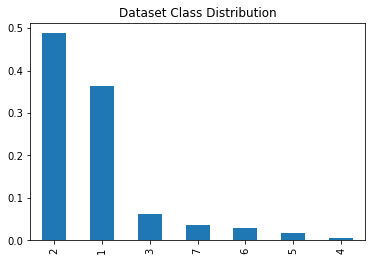

In [6]:
df['Cover_Type'].value_counts(ascending=False,normalize=True).plot.bar(title='Dataset Class Distribution');
plt.show()

# Conjunto de entrenamiento y test

Divide los datos en conjunto de entrenamiento y test (70% entrenamiento y 30%). Para ello deberás leer el fichero una sola vez y guardar los resultados en dos ficheros distintos: `train.csv` y `test.csv`.

Recuerda que no puedes cargar los datos en memoria en su totalidad y usar `train_test_split`.

In [7]:
BATCH_SIZE = 100000
OBJ_VAR = 'Cover_Type'
TEST_SIZE = 0.3
STRATIFIED = True
PATH_DATA = 'dataset/covtype.csv'
PATH_TRAIN = 'dataset/train.csv'
PATH_TEST = 'dataset/test.csv'

In [8]:
""" Funciín que nos permite partir en una parte de train y test un dataset de entrada.
Se le puede indicar el tamaño de la parte de test que queremos generar, así como que los datos 
estén estratificados"""

def split_data (my_df,my_obj_var,test_size=.3,stratified=False):
    a_aux_test= np.empty(0)
    a_aux_train= np.empty(0)
#     print(len(my_df))
#     print(my_df.head(2))
    my_df.reset_index(inplace=True,drop=True)
    # Con estratificación
    if stratified:
        # Recogemos los grupos que hay de la variable objetivo en el dataset
        grupos=list(my_df.groupby(my_obj_var).groups.keys())
#         print(grupos)

        for grupo in grupos:
            #Capturamos los indicices de cada uno de los elementos de ese grupo
            indices=np.array(my_df.groupby(my_obj_var).groups.get(grupo))
            numero_elementos=len(indices)
#             print(numero_elementos)
            #Repartimos los indices en la prooporción que nos indica el test_size
            a_aux_test=np.append(a_aux_test,indices[:int(numero_elementos*test_size)])
            a_aux_train=np.append(a_aux_train,indices[int(numero_elementos*test_size):])
    else:# Sin estratificación.
        
        indices = np.array(my_df.index)
        numero_elementos=len(indices)
        #Repartimos los indices en la prooporción que nos indica el test_size
        a_aux_test=np.append(a_aux_test,indices[:int(numero_elementos*test_size)])
        a_aux_train=np.append(a_aux_train,indices[int(numero_elementos*test_size):])

    #Desordenamos los indices.
    random.shuffle(a_aux_test)
    random.shuffle(a_aux_train)
    
    #Seleccionamos los dataset de train y test conforme los indices elegidos.
    df_aux_test = my_df.iloc[a_aux_test]
    df_aux_train = my_df.iloc[a_aux_train]
        
    return df_aux_train,df_aux_test

Cargado batch de datos de 100000 elementos.
Cargado df_train de datos de 70002 elementos.
Cargado df_test de datos de 29998 elementos.


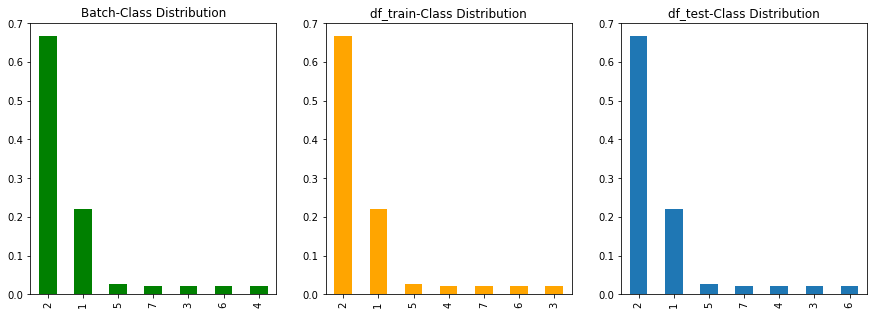

Cargado batch de datos de 100000 elementos.
Cargado df_train de datos de 70002 elementos.
Cargado df_test de datos de 29998 elementos.


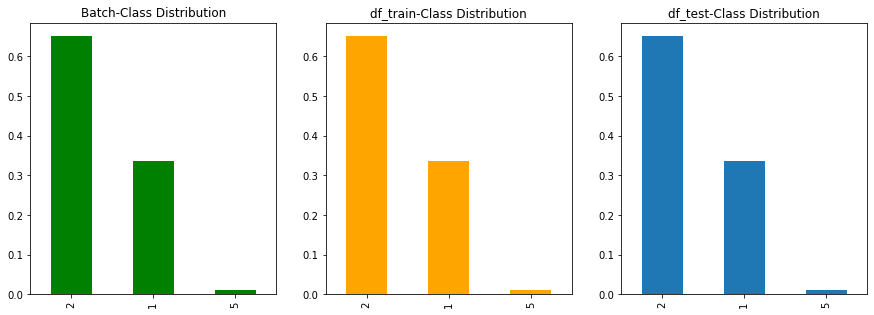

Cargado batch de datos de 100000 elementos.
Cargado df_train de datos de 70003 elementos.
Cargado df_test de datos de 29997 elementos.


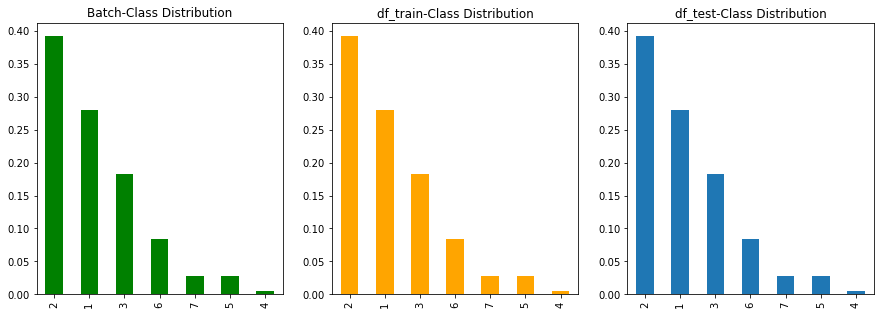

Cargado batch de datos de 100000 elementos.
Cargado df_train de datos de 70003 elementos.
Cargado df_test de datos de 29997 elementos.


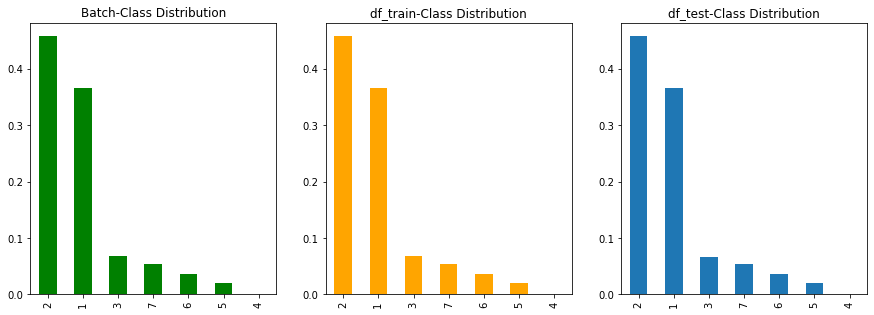

Cargado batch de datos de 100000 elementos.
Cargado df_train de datos de 70003 elementos.
Cargado df_test de datos de 29997 elementos.


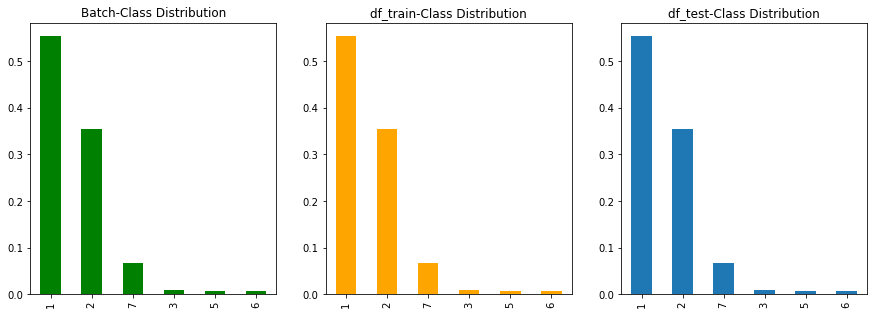

Cargado batch de datos de 81012 elementos.
Cargado df_train de datos de 56711 elementos.
Cargado df_test de datos de 24301 elementos.


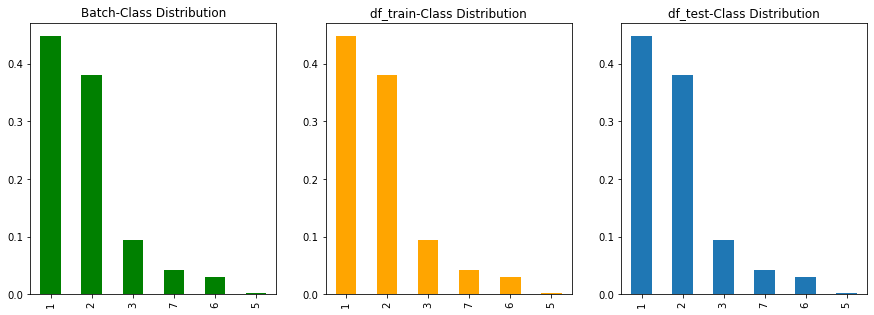

In [9]:
""" Esta parte permite generar los ficheros de train y test generandolos por bloques"""      
with open(PATH_DATA, 'r') as file:
    iterator = pd.read_csv(file, chunksize=BATCH_SIZE)

    # Si el fichero de test existe lo borramos.
    if os.path.exists(PATH_TEST):
        os.remove(PATH_TEST)
    # Si el fichero de train existe lo borramos.
    if os.path.exists(PATH_TRAIN):
        os.remove(PATH_TRAIN)
        
    # Variable que se activa para que la primera vez escriba las cabeceras.
    header_write=True
      
    for batch in iterator:
        
        print (f'Cargado batch de datos de {len(batch)} elementos.')
            
        df_train,df_test=split_data(batch,OBJ_VAR,TEST_SIZE,stratified=STRATIFIED)
        
        print (f'Cargado df_train de datos de {len(df_train)} elementos.')
        print (f'Cargado df_test de datos de {len(df_test)} elementos.')
       
        # Visualizamos las distribuciones de las clases en el batch original y en el train y test generados.
        # Con esto podemos observar si la distribución de las clases sigue siendo la misma en train y test.
        plt.subplots(figsize=(15, 5))
        plt.subplot(131)
        batch[OBJ_VAR].value_counts(ascending=False,normalize=True).plot.bar(title='Batch-Class Distribution',color="green");
        plt.subplot(132)
        df_train[OBJ_VAR].value_counts(ascending=False,normalize=True).plot.bar(title='df_train-Class Distribution',color="orange");
        plt.subplot(133)
        df_test[OBJ_VAR].value_counts(ascending=False,normalize=True).plot.bar(title='df_test-Class Distribution');
        plt.show()
        
        # Guradamos en el fichero de test
        df_test.to_csv(PATH_TEST,mode='a',header=header_write,index=False)
        # Guradamos en el fichero de train
        df_train.to_csv(PATH_TRAIN,mode='a',header=header_write,index=False)
        # Una vez hemmos escrito la cabacera descativamos la variable para que ya no lo vuelva escribir.
        if header_write:
            header_write=False
            

# ¿Qué deberías hacer si quieres hacer que la división entre entrenamiento y test sea estratificado?

Te recuerdo que una división se denomina estratificada cuando garantiza que la distribución de la variable objetivo se mantiene entre el conjunto de entrenamiento y test. 

No hace falta que implementes la función, con explicar como lo resolverías es suficiente.

**Respuesta:**  Para que la división fuera estratificada, se resolvería trasladando la proporciones de la division de train a test a cada uno de los grupos que pudieran conformar cada uno de los valores que pudiera contemplar la variable objetivo, independientemente de que un grupo fuera de clase fuera más numeroso y otro fuera menos numeroso. 

El ejemplo lo he realizado en la función **split_data** del aparatdo anterior que servirá para crear un fichero de train y test con las mismas proporciones (estratificado). En el ejemplo hemos fijado un 30% para el conjunto de test y un 70% para el train. Y la solución ha sido agrupar por los ditintos valores que tiene la variable objetivo/predicha **Cover_Type** y aplicar para cada grupo la división de 30% de los registros para test y el 70% pra train, así para todos los grupos.

# Entrenamiento incremental

Entrena de forma incremental un `Perceptron` para este conjunto de datos. El dataset de test lo puedes cargar en memoria en su totalidad. Te recomiendo que utilices funciones al menos con el preprocesamiento para poder reutilizarlo.

Intenta obtener los mejores resultados posibles. Algunas de las técnicas explicadas en el worksheet te ayudarán a obtener mejores resultados.

Por último indica cual sería el porcentaje de acierto del modelo. ¿es único? ¿cambia a lo largo del tiempo?.

In [10]:
"""Función que permite generar la parte Preditora X y la parte Predicha y a partir de un dataset y la variable
objetivo"""
def creatre_X_y (my_df, my_obj_var):

    X=my_df.loc[:].drop(my_obj_var,axis=1).to_numpy()
    y=my_df[my_obj_var].to_numpy()
    
    return X,y

In [23]:
""" Función que permitirá entrenar en bacthes. Tine como parámetros:
    path_train -> Ruta donde se encuentra el dataset de train.
    model -> El modelo que se utiliza para hacer el entrenamiento y la predicción.
    normalizator -> El nomralizador del dataset.
    my_batch_size -> El tamaño del batch con el que iremos leyendo."""

def train_with_batches(path_train, model, normalizator=None, my_batch_size=100000):
    """
    Entrena un modelo con minibatches y devuelve el mismo una vez entrenado.
    """    
    classes = np.unique([1,2,3,4,5,6,7]) # Clases que tenemos en el dataset.

    with open(path_train, 'r') as file:
        iterator = pd.read_csv(file, chunksize=my_batch_size)
        for batch in iterator:
#             print (f'Cargado batch de datos de {len(batch)} elementos.')
            X_train,y_train=creatre_X_y (batch,OBJ_VAR)
            # Normalizamos utilizando partial_fit ya que vamos entrenando por batchs
            if (normalizator) :
                X_train=normalizator.fit(X_train).transform(X_train) 
            model.partial_fit(X_train, y_train, classes)
            
    return model     

In [24]:
# Leemos el dataset de test, reduciendo a la mitad la memoria que ocupa, obligando que el tipo sea int32 en vez
# de int64.
df_test = pd.read_csv(PATH_TEST,index_col=False,dtype='int32')
X_test,y_test=creatre_X_y(df_test,OBJ_VAR')

In [25]:
model_incremental=train_with_batches(PATH_TRAIN, Perceptron(random_state=42),my_batch_size=BATCH_SIZE)
resultados = model_incremental.score(X_test, y_test)
print(f'Porcentaje de acierto: {(resultados*100):.4f} %')

Porcentaje de acierto: 54.9126 %


### Normalización

In [26]:
#Utilizamos StandarScaler para normalizar los datos.
from sklearn.preprocessing import StandardScaler
scaler_Train = StandardScaler()
scaler_Test = StandardScaler()

In [27]:
df_test = pd.read_csv(PATH_TEST,index_col=False,dtype='int32')
X_test,y_test=creatre_X_y(df_test,OBJ_VAR)
X_test=scaler_Test.fit(X_test).transform(X_test)

In [28]:
model_incremental=train_with_batches(PATH_TRAIN,
                                     Perceptron(random_state=42,
                                                eta0=0.1, 
                                                max_iter=200000),
                                     scaler_Train,
                                     BATCH_SIZE)
resultados = model_incremental.score(X_test, y_test)
print(f'Porcentaje de acierto: {(resultados*100):.4f} %')

Porcentaje de acierto: 55.7944 %


* **Respuesta:** 
    * Los resultados mejoran al realizarle un proceso de Normalización, en este caso usando un StandardScaler, aunque se ha hecho pruebas con MinMaxScaler, pero los resultados no eran tan satisfactorios, debido a que seguramante se vea bastante afectado por outlayers.
    * A nivel general y por lo visto en los entrenamientos, el resultado puede fluctuar dependiendo principalmente del tamaño del batchsize, a mayor tamaño los valores son más estables, a menor tamaño a variabilidad de los reusltados es mayor y a nivel global el score es más bajo. 


# Entrenamiento no incremental

Carga el dataset completo en memoria, dividelo en conjunto de entrenamiento y test y entrenalo en un único paso. Calcula el porcentaje de acierto. 

In [17]:
# Cargamos los datos de entreno y test
df_train = pd.read_csv(PATH_TRAIN,index_col=False,dtype='int32')
df_test = pd.read_csv(PATH_TEST,index_col=False,dtype='int32')
#Mostramos información de la parte de entreno.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406724 entries, 0 to 406723
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           406724 non-null  int32
 1   Aspect                              406724 non-null  int32
 2   Slope                               406724 non-null  int32
 3   Horizontal_Distance_To_Hydrology    406724 non-null  int32
 4   Vertical_Distance_To_Hydrology      406724 non-null  int32
 5   Horizontal_Distance_To_Roadways     406724 non-null  int32
 6   Hillshade_9am                       406724 non-null  int32
 7   Hillshade_Noon                      406724 non-null  int32
 8   Hillshade_3pm                       406724 non-null  int32
 9   Horizontal_Distance_To_Fire_Points  406724 non-null  int32
 10  Wilderness_Area1                    406724 non-null  int32
 11  Wilderness_Area2                    406724 non-null 

In [18]:
# Generamos parte X,y de la parte Train y Test.
X_train_no_inc,y_train_no_inc=creatre_X_y(df_train,OBJ_VAR)
X_test_no_inc,y_test_no_inc=creatre_X_y(df_test,OBJ_VAR)

# Usamos StandardScaler para normalizar/estandarizar los valores del dataset.
scaler_Train = StandardScaler()
scaler_Test = StandardScaler()

#Normalizamos por separado la parte de Train y la parte de Test.
X_train_no_inc=scaler_Train.fit(X_train_no_inc).transform(X_train_no_inc)
X_test_no_inc=scaler_Test.fit(X_test_no_inc).transform(X_test_no_inc)

#Instanciamos el Perceptron.
cls_no_incremental=Perceptron(random_state=42,
                              eta0=0.1,
                              max_iter=200000,
                              early_stopping=True)
#Realizamos el entrenamiento y sacamos el score comparando con la parte de test.
resultados_no_inc=cls_no_incremental.fit(X_train_no_inc,y_train_no_inc).score(X_test_no_inc, y_test_no_inc)
                    
print(f'Porcentaje de acierto: {(resultados_no_inc*100):.4f} %')

Porcentaje de acierto: 63.0669 %


# Conclusiones

Compara los resultados obtenidos del aprendizaje incremental con el no incremental. Explica las ventajas e inconvenientes de cada uno de los enfoques. 

Indica también algún punto de mejora que se ocurra.

* **Respuesta:** Los resultados son mejores en el **no incremental** que en el **incremental**. Y dentro del incremental se mejoran resultados normalizando y parametrizando con otros valores y parámetros el modelo, en este caso el Perceptron. Como principales PROS y CONTRAS para los dos tipos de entrenamiento:
    * **No Incremental:**
        * **PROS:** Se entrena con todo el dataset recogiendo toda la casuística en los datos.   Todos los modelos soportan el entranamiento No Incremental
        * **CONTRAS:** A veces no se puede disponer de todos los datos, bien por que los datos se generan en tiempo real, o por partes, bien por que no se dispone de capacidad de hardware para poder tenerlos cargados en memoria.
        
    * **No Incremental:**
        * **PROS:** Es ideal cuando tenemos limitaciones tanto del tipo "hardware" y no hay capacidad para poder tener cargados los datos en memoria como por la carateristicas de los datos en el que no se disponen de la totalidad en el momento del entreno ya que se van generando en tiempo real, o se recogen en tandas o batchs.
        * **CONTRAS:** No todos los modelos soportan el entreno incremental, como por ejemplo los Knn, SVM. Y los que pueden no están permitidos todos los parámetros.
        
    * **Como acciones de mejora:**
        * Utilizar un modelo en principio más complejo como un MLPClassifier,SGDClassifier
        * Reducir dimensionalidad con un IncrementalPCA que admite partial_fit.
        * Aumentar en la medida de lo posible el tamaño del batch_size.
       
        